<a href="https://colab.research.google.com/github/bartolomeoadrian/computer-vision/blob/main/exam_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar librerías

In [1]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from base64 import b64encode

# Video original

In [2]:
video_url = 'https://raw.githubusercontent.com/bartolomeoadrian/computational-vision/refs/heads/main/assets/videos/football_match.mp4'
r = requests.get(video_url)

with open("/content/football_match.mp4", "wb") as f:
    f.write(r.content)

# Función auxiliar para dibujar imagenes

In [3]:
def show_images(images, rows=1, cols=2, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    for i, (title, img) in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray" if img.ndim==2 else None)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Imagen para realizar pruebas

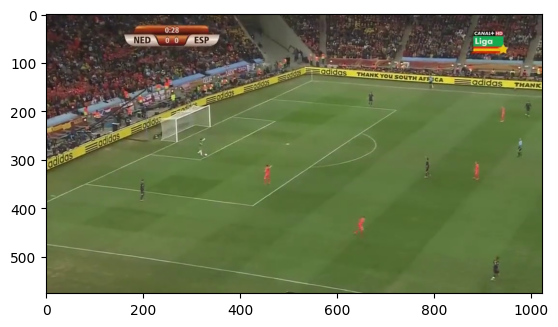

In [4]:
cap = cv2.VideoCapture('/content/football_match.mp4')

cap.set(cv2.CAP_PROP_POS_MSEC, 30 * 1000)

ret, frame = cap.read()
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

if ret:
    plt.imshow(frame_rgb)
    plt.show()
else:
    print("No se pudo leer el frame.")

# Detección de limites de la cancha

In [5]:
def segment_field_green(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    lower_green = np.array([35, 40, 40], dtype=np.uint8)
    upper_green = np.array([85, 255, 255], dtype=np.uint8)

    mask = cv2.inRange(hsv, lower_green, upper_green)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Keep only the largest contour (field)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        filled = np.zeros_like(mask)
        cv2.drawContours(filled, [largest], -1, 255, thickness=cv2.FILLED)
        return filled
    return mask

def draw_lines(canvas, lines, color=(255, 255, 0), thickness=2):
    """
    Draw Hough lines on the canvas.
    """
    if lines is None:
        return
    for ln in lines:
        x1, y1, x2, y2 = ln[0]
        cv2.line(canvas, (x1, y1), (x2, y2), color, thickness)

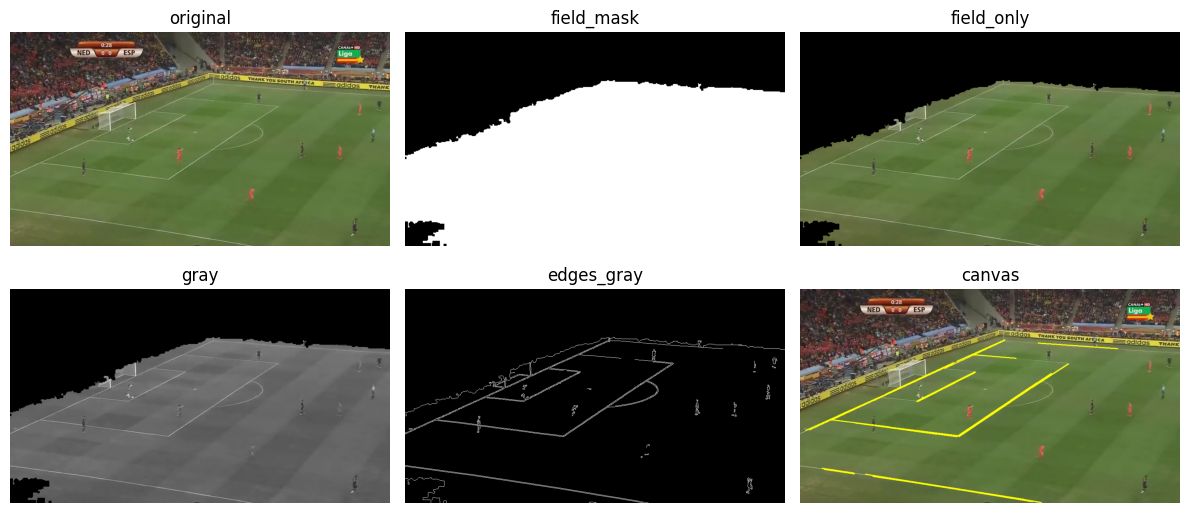

In [6]:
canvas = frame_rgb.copy()

# 1) Segment field
field_mask = segment_field_green(frame_rgb)
field_only = cv2.bitwise_and(frame_rgb, frame_rgb, mask=field_mask)

# Combine edges from luminance and white mask
gray = cv2.cvtColor(field_only, cv2.COLOR_BGR2GRAY)
edges_gray = cv2.Canny(gray, 50, 150, apertureSize=3)

# Hough probabilistic
lines = cv2.HoughLinesP(
    edges_gray,
    rho=1,
    theta=np.pi/180,
    threshold=80,
    minLineLength=80,
    maxLineGap=10
)

# 3) Draw results
draw_lines(canvas, lines, color=(255, 255, 0), thickness=2)

show_images([
    ("original", frame_rgb),
    ("field_mask", field_mask),
    ("field_only", field_only),
    ("gray", gray),
    ("edges_gray", edges_gray),
    ("canvas", canvas)
], rows=3, cols=3)

# Función para dibujar límites de la cancha

In [7]:
def draw_field(frame, canvas):
    """
    Detect white straight lines within the green field area using Canny + HoughLinesP.
    """
    # Keep only the field area
    field_mask = segment_field_green(frame)
    field_only = cv2.bitwise_and(frame, frame, mask=field_mask)

    # Combine edges from luminance and white mask
    gray = cv2.cvtColor(field_only, cv2.COLOR_BGR2GRAY)
    edges_gray = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Hough probabilistic
    lines = cv2.HoughLinesP(
        edges_gray,
        rho=1,
        theta=np.pi/180,
        threshold=80,
        minLineLength=80,
        maxLineGap=10
    )

    draw_lines(canvas, lines, color=(255, 255, 0), thickness=2)

# Detectar jugadores por color de camiseta y dentro de la cancha

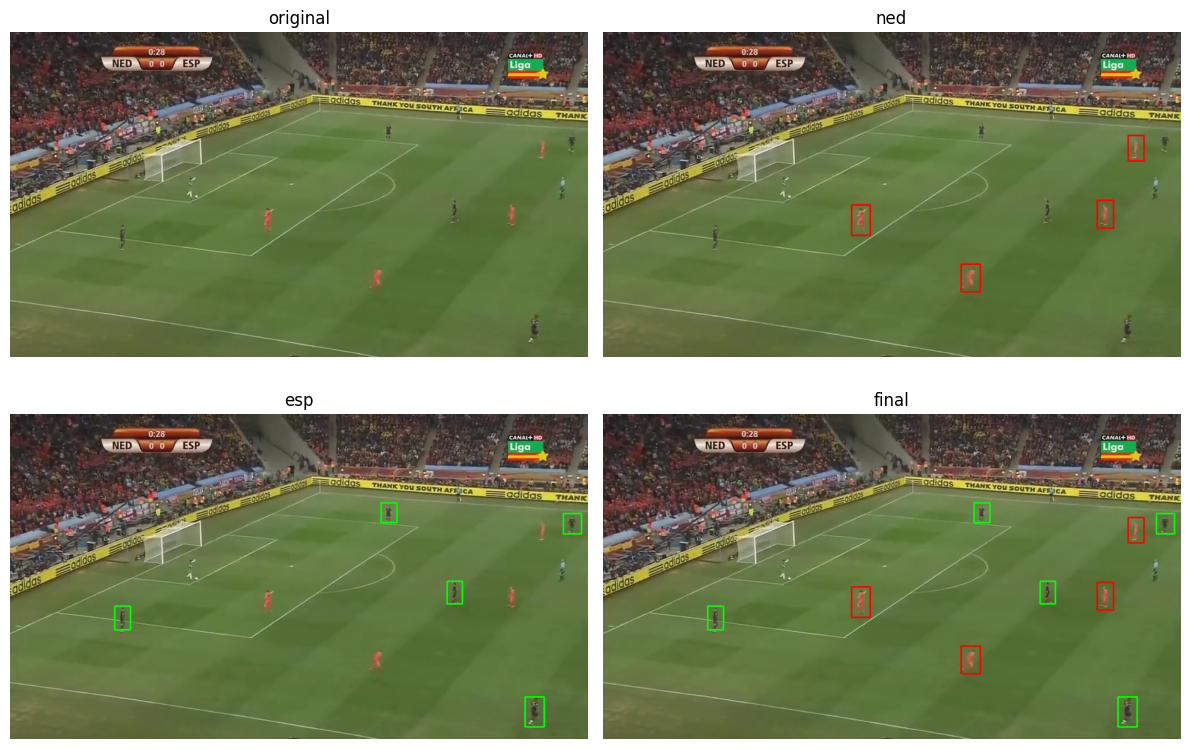

In [8]:
def detect_players_by_color(frame, canvas, jersey_rgb, tol=40,
                            min_area=40, max_area=600,
                            box_color=(0,0,255), thickness=2, margin=10):
    field_mask = segment_field_green(frame)

    r, g, b = jersey_rgb
    lower = np.array([max(0,   r - tol), max(0,   g - tol), max(0,   b - tol)], dtype=np.uint8)
    upper = np.array([min(255, r + tol), min(255, g + tol), min(255, b + tol)], dtype=np.uint8)

    team_mask = cv2.inRange(frame, lower, upper)
    team_mask = cv2.bitwise_and(team_mask, field_mask)

    boxes = []
    cnts, _ = cv2.findContours(team_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        a = cv2.contourArea(c)
        if min_area <= a <= max_area:
            x,y,w,h = cv2.boundingRect(c)
            if h > w and h > 10:
                boxes.append((x,y,w,h))

                x1 = max(0, x - margin)
                y1 = max(0, y - margin)
                x2 = min(frame.shape[1], x + w + margin)
                y2 = min(frame.shape[0], y + h + margin)

                cv2.rectangle(canvas, (x1, y1), (x2, y2), box_color, thickness)

ned = frame_rgb.copy()
detect_players_by_color(frame_rgb, ned, tol=60, jersey_rgb=(200, 83, 73), box_color=(255,0,0))

esp = frame_rgb.copy()
detect_players_by_color(frame_rgb, esp, tol=40, jersey_rgb=(47, 50, 41), box_color=(0,255,0))

final = frame_rgb.copy()
detect_players_by_color(frame_rgb, final, tol=60, jersey_rgb=(200, 83, 73), box_color=(255,0,0))
detect_players_by_color(frame_rgb, final, tol=40, jersey_rgb=(47, 50, 41), box_color=(0,255,0))

show_images([
    ("original", frame_rgb),
    ("ned", ned),
    ("esp", esp),
    ("final", final),
], rows=2, cols=2)


# Generar video

In [9]:
cap = cv2.VideoCapture('/content/football_match.mp4')

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Define output video writer
out = cv2.VideoWriter('/content/football_match_final.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Process frames
with tqdm(total=total_frames, desc='Processing video') as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb_final_video = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        canvas = frame_rgb_final_video.copy()
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

        draw_field(frame_rgb_final_video, canvas)
        detect_players_by_color(frame_rgb_final_video, canvas, tol=60, jersey_rgb=(200, 83, 73), box_color=(255,0,0))
        detect_players_by_color(frame_rgb_final_video, canvas, tol=40, jersey_rgb=(47, 50, 41), box_color=(0,255,0))

        out.write(canvas)
        pbar.update(1)

cap.release()
out.release()

Processing video: 100%|██████████| 7517/7517 [05:24<00:00, 23.19it/s]


# Resultado